In [4]:
#!pip install PyShp

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import fiona
import pandas as pd
import shapely
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
import geopandas as gpd
import descartes
import shapefile
from descartes.patch import PolygonPatch


### zone index from 1 to 263

In [3]:
df = pd.read_csv('../data/trip_cleaned.csv')

In [16]:
a = sorted(df.pickup_taxizone_id.unique())
b = sorted(df.dropoff_taxizone_id.unique())
# 1~263

### find adjacent zones 
(zone id from 0 to 262, converted to 1~263)

In [88]:
poly_list = [] # len = 263
shp_file = '../data/NYC Taxi Zones/taxi_zones.shp'
taxi_zones = fiona.open(shp_file)

adjacent = []
for i in range(len(taxi_zones)):
    zone1 = taxi_zones[i]
    shape1 = shapely.geometry.asShape(zone1['geometry'])
    for j in range(i+1, len(taxi_zones)):
        zone2 = taxi_zones[j]
        shape2 = shapely.geometry.asShape(zone2['geometry'])
        if (shape1.intersects(shape2)):
            adjacent.append([i+1,j+1])

In [111]:
adjacent[:10]

[[2, 33],
 [2, 137],
 [3, 32],
 [3, 51],
 [3, 83],
 [3, 184],
 [3, 185],
 [3, 243],
 [3, 257],
 [4, 74]]

### save to csv

In [108]:
df = pd.DataFrame(data=adjacent, columns=["zone1", "zone2"])

In [110]:
df.to_csv('../data/adjacent_zone.csv', index=False)

## Test function

In [11]:

def is_adjacent(src, dst):
    """is two taxi zones adjacent.
    Parameters
    ----------
    src : int
        taxi zone 1
    dst : int
        taxi zone 2
    Returns
    -------
    bool
    """
    #raise NotImplementedError()
    
    ad = pd.read_csv('../data/adjacent_zone.csv')
    if dst<src:
        a = dst
        b = src
        r = ad.loc[(ad.zone1 == a)&(ad.zone2 == b)]
    else:
        r = ad.loc[(ad.zone1 == src)&(ad.zone2 == dst)]
    
    return (len(r)>0)

In [123]:
is_adjacent(33,2)

True

### plot zones

In [8]:
sf = shapefile.Reader('../data/NYC Taxi Zones/taxi_zones.shp')
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [9]:
shp_dic

{'borough': 0,
 'location_i': 1,
 'objectid': 2,
 'shape_area': 3,
 'shape_leng': 4,
 'zone': 5}

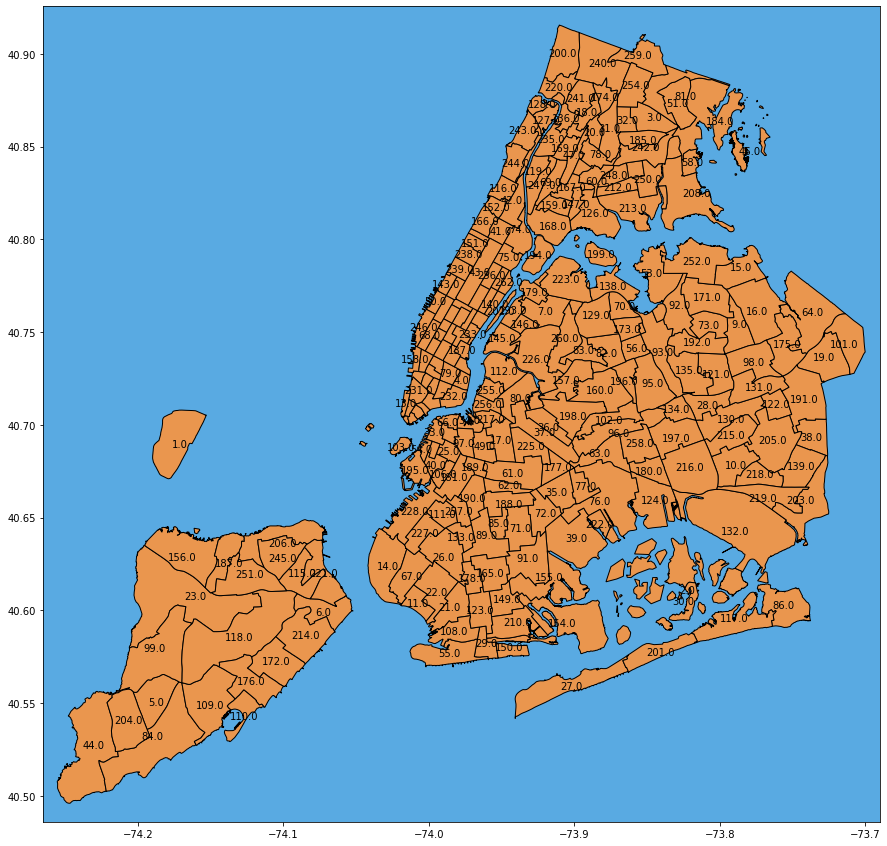

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
draw_zone_map(ax, sf)

In [ ]:
'''
sf = gpd.read_file('../data/NYC Taxi Zones/taxi_zones.shp')
sf.plot()
'''

Functions:

In [6]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['shape_area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [7]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max